<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-tf-cnn/blob/main/3_l1_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning using *InceptionV3* base model**

Transfer learning is leveraging trained layers of existing model & adding one's own layers to fit desired application

Steps to setup pretrained model:

1.   Set input shape to fit our application
2.   Pick & freeze convolution layers to take advantage of the features it has learned already
3.   Add dense layers that will be trained




We will use convolution layer from: [***InceptionV3***](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Farxiv.org%2Fabs%2F1512.00567) (a model that is already been trained on a large dataset to recognize a wide variety of objects in images)

Download pre-trained **weights** (we will be using our own weights, not the one that is already built in on Tensorflow's InceptionV3)

**Note**: ***no top*** means it excludes the fully connected layer

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-24 15:14:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   201MB/s    in 0.4s    

2023-09-24 15:14:58 (201 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Initialize base model

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 # Import InceptionV3 pre-trained model (Tensorflow already has it)

# reference weights file that has been downloaded
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# initialize base model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False, # remove the dense layer
                                weights=None) # not use the default weights

Load pre-trained weights to the base model

In [3]:
pre_trained_model.load_weights(local_weights_file)

Freeze the weights of the layers (so it won't be trained)

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Print model summary

In [5]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

Choose desired last layer (`mixed7`)

Couple of consideration not to use up to the last layer:
*   Layers become more specialized & detailed as it go deeper. If one's new task is somewhat related but not exactly the same, `mixed7` would already capture lot of relevant information
*   Save train time



In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print(f'last layer output shape: {last_layer.output_shape}')

last_output = last_layer.output # get output from `mixed7` layer

last layer output shape: (None, 7, 7, 768)


Add dense layer for the classifier
*   This will be the layer that will be trained, to recognize cats & dogs



In [7]:
from tensorflow.keras import layers

x = layers.Flatten()(last_output) # pass `last_output` to be Flattened
x = layers.Dense(1024, activation='relu')(x) # pass x (Flattened layers) to dense layer
x = layers.Dropout(0.2)(x) # make some neurons in Dense layer dropped out, reduce chance of overfitting
x = layers.Dense(1, activation='sigmoid')(x)

***Dropout*** Theory:
*   It will drop out some random neurons
*   Neighboring neurons often end up with similar weights, it could lead to overfitting. Dropping some out at random can help overfit
*   A neuron can over-weigh the input from neuron in the previous layer, and can over specialize (know so well) some features. Dropping out can break this bad habit

Append the dense network to the base model

In [8]:
from tensorflow.keras import Model

model = Model(pre_trained_model.input, x) # create model by combining 2 sets of layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

Set training parameters

In [9]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Download dataset

In [10]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-09-24 15:15:10--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   119MB/s    in 0.5s    

2023-09-24 15:15:10 (119 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Extract dataset

In [11]:
import os
import zipfile
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

Referencing directories

In [12]:
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Make ImageDataGenerator

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)

Flow images using generator

In [14]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Train the model

In [15]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_steps=50,
                    verbose=2)

Epoch 1/20
100/100 - 31s - loss: 0.3587 - accuracy: 0.8480 - val_loss: 0.1333 - val_accuracy: 0.9500 - 31s/epoch - 312ms/step
Epoch 2/20
100/100 - 17s - loss: 0.2144 - accuracy: 0.9095 - val_loss: 0.0941 - val_accuracy: 0.9630 - 17s/epoch - 171ms/step
Epoch 3/20
100/100 - 18s - loss: 0.1821 - accuracy: 0.9195 - val_loss: 0.1167 - val_accuracy: 0.9560 - 18s/epoch - 180ms/step
Epoch 4/20
100/100 - 18s - loss: 0.1724 - accuracy: 0.9290 - val_loss: 0.0964 - val_accuracy: 0.9640 - 18s/epoch - 180ms/step
Epoch 5/20
100/100 - 18s - loss: 0.1740 - accuracy: 0.9385 - val_loss: 0.0884 - val_accuracy: 0.9640 - 18s/epoch - 180ms/step
Epoch 6/20
100/100 - 17s - loss: 0.1544 - accuracy: 0.9385 - val_loss: 0.1095 - val_accuracy: 0.9580 - 17s/epoch - 174ms/step
Epoch 7/20
100/100 - 17s - loss: 0.1291 - accuracy: 0.9510 - val_loss: 0.0926 - val_accuracy: 0.9640 - 17s/epoch - 173ms/step
Epoch 8/20
100/100 - 17s - loss: 0.1296 - accuracy: 0.9515 - val_loss: 0.0851 - val_accuracy: 0.9670 - 17s/epoch - 170

Evaluate the results

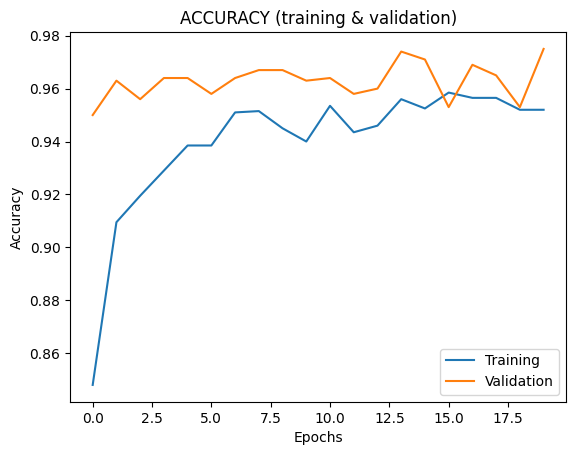

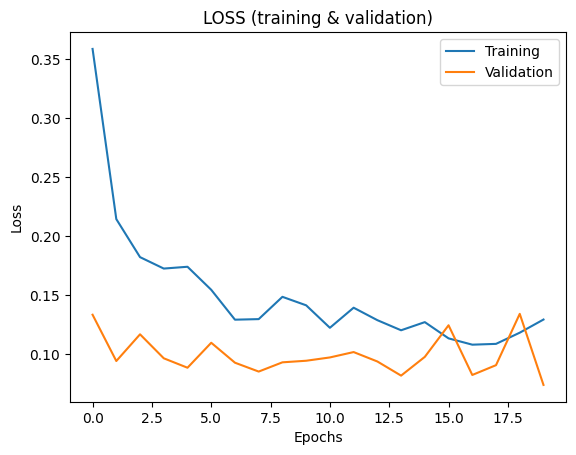

In [17]:
import matplotlib.pyplot as plt

# get data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# get epochs data
epochs = range(len(acc))

# plot accuracy data
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('ACCURACY (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss data
plt.figure()
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('LOSS (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()